# Proyecto 2

**Tema:** Predicción de enfermedades Cardíacas


|     Nombres      |      Apellidos       |     Login     |  Codigo   |
| :--------------: | :------------------: | :-----------: | :-------: |
|     Santiago     | Gonzalez Montealegre | s.gonzalez35  | 202012274 |
| Juliana Carolina |  Cardenas Barragan   | jc.cardenasb1 | 202011683 |


## Medidas de Desempeño - Estructura - Restricciones

## K-Fold Cross Validation

## Librerías Requeridas

In [1]:
import pandas as pd
from pgmpy.estimators import PC
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

## Carga de Datos

In [2]:
df = pd.read_csv("../../../Data/Transformed/Discrete.csv")

## K-Fold

In [3]:
variables = [column for column in list(df.columns) if column != 'heartdis']

X = df[variables].values
y = df['heartdis'].values

kf = KFold(n_splits=4, shuffle=True, random_state=1)

splits = list(kf.split(X))

## Test

In [4]:
def inferenceEvidence(evidence, model):
    
    infer = VariableElimination(model)

    prob = infer.query(variables=['heartdis'], evidence=evidence)
    
    return prob.values.tolist()

In [5]:
def getEvidence(nodes, row):
    
    evidence = {}
    for node in nodes:
        if node != 'heartdis':
            evidence[node] = (row[node])
    
    return evidence

In [6]:
def getClassification(probs):
    cero = probs[0]
    one = probs[1]
    if cero >= one:
        result = 0
    else:
        result = 1
        
    return result

In [7]:
def getMetrics(df_test):
    
    # confussion_matrix = [[None, None],[None, None]]
    
    metrics = {'TN': None, 'FP': None, 'FN': None, 'TP': None}
    
    df_needed = df_test[['heartdis', 'test']]
    
    true_negatives_df = df_needed[(df_needed['heartdis'] == df_needed['test']) & (df_needed['test'] == 0)]
    true_negatives = true_negatives_df['test'].count()
    
    false_positives_df = df_needed[(df_needed['heartdis'] != df_needed['test']) & (df_needed['test'] == 1)]
    false_positives = false_positives_df['test'].count()
    
    false_negatives_df = df_needed[(df_needed['heartdis'] != df_needed['test']) & (df_needed['test'] == 0)]
    false_negatives = false_negatives_df['test'].count()
    
    
    true_positives_df = df_needed[(df_needed['heartdis'] == df_needed['test']) & (df_needed['test'] == 1)]
    true_positives = true_positives_df['test'].count()
    
    metrics['TN'] = true_negatives
    metrics['FP'] = false_positives
    metrics['FN'] = false_negatives
    metrics['TP'] = true_positives
    
    return metrics

In [8]:
def trainModel(df_train):
    
    est = PC(data=df_train)
    estimated_model = est.estimate(variant="stable", max_cond_vars=10)
    
    model = BayesianNetwork(estimated_model)
    model.fit(data=df_train, estimator=MaximumLikelihoodEstimator)
    
    return model

In [9]:
# Iterate over the K-Fold

kfold_metrics = []
for train_index, test_index in splits:
    
    # Get the Train and Test set
    
    X_train = X[train_index]
    y_train = y[train_index]
    
    X_test = X[test_index]
    y_test = y[test_index]
    
    df_train = pd.DataFrame(X_train, columns=variables)
    df_train['heartdis'] = y_train

    df_test = pd.DataFrame(X_test, columns=variables)
    df_test['heartdis'] = y_test
    
    # Train the Model
    
    model = trainModel(df_train)
    
    nodes = model.nodes    
    
    # Test the model
    
    test = []
    for i in range(0, len(df_test)):
        row = df_test.iloc[i]
        evidence = getEvidence(nodes=nodes, row=row)
        probs = inferenceEvidence(evidence, model)
        classification = getClassification(probs)
        test.append(classification)

    df_test['test'] = test
    
    metrics = getMetrics(df_test)
    
    kfold_metrics.append(metrics)

df_performance = pd.DataFrame(kfold_metrics)

df_performance['accuracy'] = (df_performance['TN'] + df_performance['TP']) / (df_performance['TN'] + df_performance['FP'] + df_performance['FN'] + df_performance['TP'])
df_performance['precision'] = (df_performance['TP']) / (df_performance['FP'] + df_performance['TP'])
df_performance['recall'] = (df_performance['TP']) / (df_performance['FN'] + df_performance['TP'])
df_performance['f1_score'] = 2 * (df_performance['precision'] * df_performance['recall']) / (df_performance['precision'] + df_performance['recall'])
df_performance['specificity'] = (df_performance['TN']) / (df_performance['TN'] + df_performance['FP'])

  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\SGM\AppData\Local\Programs\Python\Python310\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:478: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\SGM\AppData\Local\Programs\Python\Python310\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:478: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\SGM\AppData\Local\Programs\Python\Python310\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:478: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
df_performance

,TN,FP,FN,TP,accuracy,precision,recall,f1_score,specificity
0,26,15,8,27,0.697368,0.642857,0.771429,0.701299,0.634146
1,40,5,10,21,0.802632,0.807692,0.677419,0.736842,0.888889
2,29,8,10,29,0.763158,0.783784,0.743590,0.763158,0.783784
3,37,4,17,17,0.720000,0.809524,0.500000,0.618182,0.902439


In [11]:
accuracy = df_performance['accuracy'].mean()
precision = df_performance['precision'].mean()
recall = df_performance['recall'].mean()
f1_score = df_performance['f1_score'].mean()
specificity = df_performance['specificity'].mean()

print(f'accuracy: \t {round(accuracy, 2)}')
print(f'precision: \t {round(precision, 2)}')
print(f'recall: \t {round(recall, 2)}')
print(f'f1_score: \t {round(f1_score, 2)}')
print(f'specificity: \t {round(specificity, 2)}')

accuracy: 	 0.75
precision: 	 0.76
recall: 	 0.67
f1_score: 	 0.7
specificity: 	 0.8


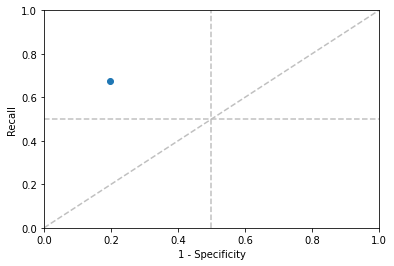

In [12]:
# Create plot
fig, ax =plt.subplots()

# Ax limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Lines for guide
ax.axvline(x=0.5, color='silver', linestyle='--')
ax.axhline(y=0.5, color='silver', linestyle='--')
x = [0, 1]
y = [0, 1]
ax.plot(x, y, color='silver', linestyle='--')

ax.scatter(1-specificity, recall)

plt.xlabel("1 - Specificity")
plt.ylabel("Recall")
plt.show()

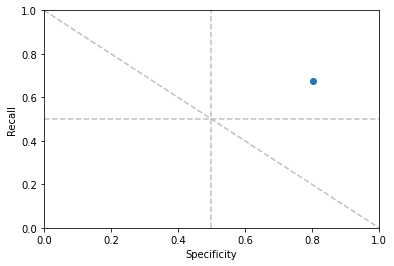

In [13]:
# Create plot
fig, ax =plt.subplots()

# Ax limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Lines for guide
ax.axvline(x=0.5, color='silver', linestyle='--')
ax.axhline(y=0.5, color='silver', linestyle='--')
x = [0, 1]
y = [1, 0]
ax.plot(x, y, color='silver', linestyle='--')

ax.scatter(specificity, recall)

plt.xlabel("Specificity")
plt.ylabel("Recall")
plt.show()